In [1]:
import numpy as np
import scipy.stats as st
from netCDF4 import Dataset
import matplotlib.pyplot as plt

In [3]:
# use this function again to get the indices for the sub-polar gyre region
def trmm_indices_for_area(area_coords, trmm_lat, trmm_lon):
    la = len(trmm_lat)
    lo = len(trmm_lon)
    n = la * lo
    indices = np.arange(n).reshape((la, lo))
    trmm_coords = np.transpose([np.repeat(trmm_lat, len(trmm_lon)), np.tile(trmm_lon, len(trmm_lat))])
    lat_max = trmm_lat[np.argmin(np.abs(trmm_lat - np.max(area_coords[:, 0])))]
    lat_min = trmm_lat[np.argmin(np.abs(trmm_lat - np.min(area_coords[:, 0])))]
    lon_max = trmm_lon[np.argmin(np.abs(trmm_lon - np.max(area_coords[:, 1])))]
    lon_min = trmm_lon[np.argmin(np.abs(trmm_lon - np.min(area_coords[:, 1])))]
    ra_indices = indices[np.where(trmm_lat == lat_min)[0][0] : np.where(trmm_lat == lat_max)[0][0] + 1 , np.where(trmm_lon == lon_min)[0][0] : np.where(trmm_lon == lon_max)[0][0] + 1 ]
    ra_indices = ra_indices.flatten()
    trmm_ra_coords = trmm_coords[ra_indices]
    d = np.zeros((len(area_coords), len(ra_indices)))
    for i in range(len(area_coords)):
        for j in range(len(ra_indices)):
            d[i, j] = np.sum(np.abs(area_coords[i] - trmm_ra_coords[j]))
    trmm_indices_area = ra_indices[np.argmin(d, axis = 1)]
    return trmm_indices_area

# Load Data

The [EN4](https://www.metoffice.gov.uk/hadobs/en4/) dataset provides a record of the monthly sea salinity at 42 different depths around the globe from 1900-2024. There is a seperate dataset for each month.

In [4]:
years = np.arange(1900, 2020)
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
tlen = int(years.shape[0] * 12)

lat = Dataset('data/EN4/EN.4.2.1.f.analysis.g10.202109.nc').variables['lat'][:] # (-83 - 89)
lon = Dataset('data/EN4/EN.4.2.1.f.analysis.g10.202109.nc').variables['lon'][:] # (1 - 360)
depth = Dataset('data/EN4/EN.4.2.1.f.analysis.g10.202109.nc').variables['depth'][:] # 42 depths (5 - 5350m)
salt = Dataset('data/EN4/EN.4.2.1.f.analysis.g10.202109.nc').variables['salinity'][0, 0, :,:] # salinity (1, depth, lat, lon)  

la = len(lat) # number of latitudes
lo = len(lon) # number of longitudes
n = la * lo # total number of co-ords (excluding depth)

dth = 300 # only consider salinity under 300m in depth
weights = np.cos(lat * 2 * np.pi / 360) # weights to account for the curvature of the earth along latitudes
dlen = np.where(depth < dth)[0].shape[0] # number of depths under 300m
area_ceaser_coords = np.loadtxt('area_ceaser.txt') # co-ordiantes of the sub-polar gyre region
area_ceaser_indices_sal = trmm_indices_for_area(area_ceaser_coords, lat, lon)

## NN1

$(45 - 65^\circ N)$ Salinity concetration in the Northern North Atlantic

## NN2

$(54 - 62^\circ N), (26 - 62^\circ W)$ This EWS was identified through simulations.

## N

$(10 - 40^\circ N)$ Salinity concentration in the North Atlantic

## S

$(10 - 34^\circ S)$ A salinity pileup in the South Atlantic

In [5]:
# results for monthly salinity indices
sal = np.zeros((tlen))
sal_s = np.zeros((tlen))
sal_n = np.zeros((tlen))
sal_sg = np.zeros((tlen))
sal_klus = np.zeros((tlen))
sal_global = np.zeros((tlen, la, lo))

# calculate monthly spacial means for different regions
i = 0
for y in years:
    if y < 2020:
        for m in range(12):
            dat = Dataset('data/EN4/EN.4.2.1.f.analysis.g10.%s%s.nc'%(y, months[m]))
            # NN1
            # take the means along the longitudes
            sal_temp = np.nanmean(dat.variables['salinity'][0, depth < dth, np.logical_and(lat > 44, lat < 66), np.logical_or(lon > 289, lon < 30)], axis = 2)  
            # take means along the latitudes while accounting for curvature of the earth
            sal_temp = np.average(sal_temp, weights = weights[np.logical_and(lat > 44, lat < 66)], axis = 1)
            # take maens along depth
            sal[i] = sal_temp.mean()
            # N
            sal_n_temp = np.nanmean(dat.variables['salinity'][0, depth < dth, np.logical_and(lat > 10, lat < 40), np.logical_or(lon > 280, lon < 30)], axis = 2)
            sal_n_temp = np.average(sal_n_temp, weights = weights[np.logical_and(lat > 10, lat < 40)], axis = 1)
            sal_n[i] = sal_n_temp.mean()
            # S
            sal_s_temp = np.nanmean(dat.variables['salinity'][0, depth < dth, np.logical_and(lat > -34, lat < -10), np.logical_or(lon > 289, lon < 30)], axis = 2)
            sal_s_temp = np.average(sal_s_temp, weights = weights[np.logical_and(lat > -34, lat < -10)], axis = 1)
            sal_s[i] = sal_s_temp.mean()
            # NN2
            sal_klus_temp = np.nanmean(dat.variables['salinity'][0, depth < dth, np.logical_and(lat > 55, lat < 62), np.logical_and(lon > 298, lon < 334)], axis = 2)
            sal_klus_temp = np.average(sal_klus_temp, weights = weights[np.logical_and(lat > 55, lat < 62)], axis = 1)
            sal_klus[i] = sal_klus_temp.mean()
            # mean salinity of sub-polar gyre region
            sal_sg[i] = np.nanmean(dat.variables['salinity'][0, depth < dth, :, :].reshape(dlen, la * lo)[:, area_ceaser_indices_sal])
            # mean global salinity
            sal_global[i] = np.nanmean(dat.variables['salinity'][0, depth < dth], axis = 0)

            i += 1
            
msal = np.mean(sal_global, axis = 0)
sal_global[:, msal <= 0] = np.nan

In [6]:
# centre the data
sal = sal - sal.mean()
sal_n = sal_n - sal_n.mean()
sal_s = sal_s - sal_s.mean()
sal_sg = sal_sg - sal_sg.mean()
sal_klus = sal_klus - sal_klus.mean()

# calculate the annual means
sal_am = np.zeros(years.shape[0])
sal_n_am = np.zeros(years.shape[0])
sal_s_am = np.zeros(years.shape[0])
sal_sg_am = np.zeros(years.shape[0])
sal_klus_am = np.zeros(years.shape[0])
for i in range(years.shape[0]):
    sal_am[i] = np.mean(sal[i * 12 : (i + 1) * 12])
    sal_n_am[i] = np.mean(sal_n[i * 12 : (i + 1) * 12])
    sal_s_am[i] = np.mean(sal_s[i * 12 : (i + 1) * 12])
    sal_sg_am[i] = np.mean(sal_sg[i * 12 : (i + 1) * 12])
    sal_klus_am[i] = np.nanmean(sal_klus[i * 12 : (i + 1) * 12])
    
amoc6 = -sal_am[:-1]
amoc7 = -sal_n_am[:-1]
amoc8 = -sal_s_am[:-1]
amoc9 = -sal_klus_am[:-1]
amoc10 = -sal_sg_am[:-1]

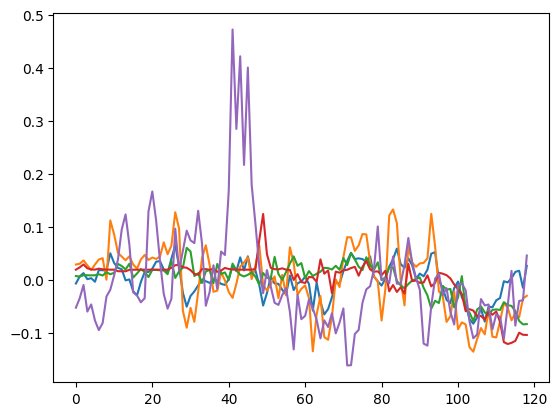

In [7]:
plt.plot(amoc6)
plt.plot(amoc9)
plt.plot(amoc7)
plt.plot(amoc8)
plt.plot(amoc10)

In [25]:
np.save('data/amoc_indices/S_nn1.npy', amoc6)
np.save('data/amoc_indices/S_n.npy', amoc7)
np.save('data/amoc_indices/S_s.npy', amoc8)
np.save('data/amoc_indices/S_nn2.npy', amoc9)
np.save('data/amoc_indices/S_sg.npy', amoc10)

Plot the regions used above on a globe. Also plot the linear trend of the salinities.

In [8]:
# returns the indices of the global co-ordinate system that overlaps with a specified rectangular region
def coordinate_indices_from_ra(lat, lon, lat_max, lat_min, lon_max, lon_min):
    la = len(lat) # latitude
    lo = len(lon) # longitude
    n = la * lo
    indices = np.arange(n).reshape((la, lo)) 
    # find the closest overlaping values 
    lat_max = lat[np.argmin(np.abs(lat - lat_max))]
    lat_min = lat[np.argmin(np.abs(lat - lat_min))]
    lon_max = lon[np.argmin(np.abs(lon - lon_max))]
    lon_min = lon[np.argmin(np.abs(lon - lon_min))]
    # get the indices corrsponding to the rectangular region
    ra_indices = indices[np.where(lat == lat_max)[0][0] : np.where(lat == lat_min)[0][0] + 1 , np.where(lon == lon_min)[0][0] : np.where(lon == lon_max)[0][0] + 1 ]
    return np.unique(ra_indices.flatten())

In [9]:
from cartopy.util import add_cyclic_point

# calculate the mean salinities for the months (October-May)
sal_ny = int(sal_global.shape[0] / 12) - 1 
saly = np.zeros((sal_ny, la, lo))
for i in range(sal_ny):
    tidx = np.array([10, 11, 12, 13, 14, 15, 16]) + i * 12
    tidx = np.array(tidx, dtype = 'int')
    saly[i] = np.nanmean(sal_global[tidx], axis = 0)

# calculate the linear trend for each salinity co-ordinate (October-May)
sal_trends = np.zeros((lat.shape[0], lon.shape[0]))
for i in range(lat.shape[0]):
    for j in range(lon.shape[0]):
        if msal[i, j] > 0:
            sal_trends[i, j] = np.polyfit(np.arange(sal_ny), saly[:, i, j], 1)[0] * 100 # linear increase in salinities over 100 years
        else:
            sal_trends[i, j] = np.nan
            
sal_trends, lonc = add_cyclic_point(sal_trends, coord=lon)
loc = lonc.shape[0]

/tmp/ipykernel_3598/4267364731.py:9: RuntimeWarning: Mean of empty slice
  saly[i] = np.nanmean(sal_global[tidx], axis = 0)


In [10]:
# get the indices for each region
nn2_idx = coordinate_indices_from_ra(lat, lonc, 54, 62, 334, 298)
nn1_idx1 = coordinate_indices_from_ra(lat, lonc, 45, 65, 361, 289) 
nn1_idx2 =  coordinate_indices_from_ra(lat, lonc, 45, 65, 30, 1)
n_idx1 = coordinate_indices_from_ra(lat, lonc, 10, 40, 361, 289) 
n_idx2 =  coordinate_indices_from_ra(lat, lonc, 10, 40, 30, 1)
s_idx1 = coordinate_indices_from_ra(lat, lonc, -34, -10, 361, 289) 
s_idx2 =  coordinate_indices_from_ra(lat, lonc, -34, -10, 30, 1)

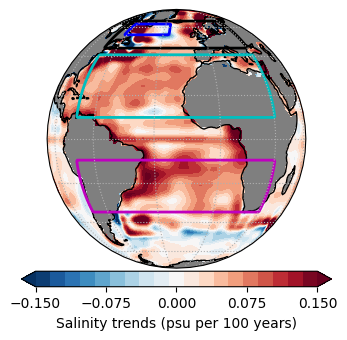

In [11]:
import cartopy.crs as ccrs
import cartopy
data_crs = ccrs.PlateCarree()

nn2_area = np.ones(la * loc)
nn2_area[nn2_idx] = -1
nn2_area = nn2_area.reshape((lat.shape[0], lonc.shape[0]))

nn1_area = np.ones(la * loc)
nn1_area[nn1_idx1] = -1
nn1_area[nn1_idx2] = -1
nn1_area = nn1_area.reshape((lat.shape[0], lonc.shape[0]))

n_area = np.ones(la * loc)
n_area[n_idx1] = -1
n_area[n_idx2] = -1
n_area = n_area.reshape((lat.shape[0], lonc.shape[0]))

s_area = np.ones(la * loc)
s_area[s_idx1] = -1
s_area[s_idx2] = -1
s_area = s_area.reshape((lat.shape[0], lonc.shape[0]))

fig = plt.figure(figsize = (4, 4))

ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=340))
ax.coastlines()
ax.contour(lonc, lat, nn1_area, [0], linestyles = 'solid', linewidths = 2., colors = 'k', transform = data_crs)
ax.contour(lonc, lat, nn2_area, [0], linestyles = 'solid', linewidths = 2., colors = 'b', transform = data_crs)
ax.contour(lonc, lat, n_area, [0], linestyles = 'solid', linewidths = 2., colors = 'c', transform = data_crs)
ax.contour(lonc, lat, s_area, [0], linestyles = 'solid', linewidths = 2., colors = 'm', transform = data_crs)
cf = ax.contourf(lonc, lat, sal_trends, levels = np.linspace(-.15,.15,20), cmap = plt.cm.RdBu_r, extend = 'both', transform = data_crs)
cbar = plt.colorbar(cf, ax = ax, orientation = 'horizontal', pad = .01, ticks=[-0.15, -0.075, 0, 0.075, 0.15], label="Salinity trends (psu per 100 years)")
gl = ax.gridlines(linestyle=":", draw_labels=False)
#gl.xlocator = mticker.FixedLocator(np.arange(-180,181,30))
#gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
ax.add_feature(cartopy.feature.LAND, color='tab:grey')

In [141]:
fig.savefig("plots/sal_regions.png")